<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/sebas/report_notebooks/autoencoder_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import utils
import train
import importlib
import visual_tools as vt
from skimage.util import random_noise
train = importlib.reload(train)
vt = importlib.reload(vt)

In [2]:
def loaders():
    traintransform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize(128),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testtransform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize(128),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 32
    num_workers = 2

    trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return trainloader, testloader

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


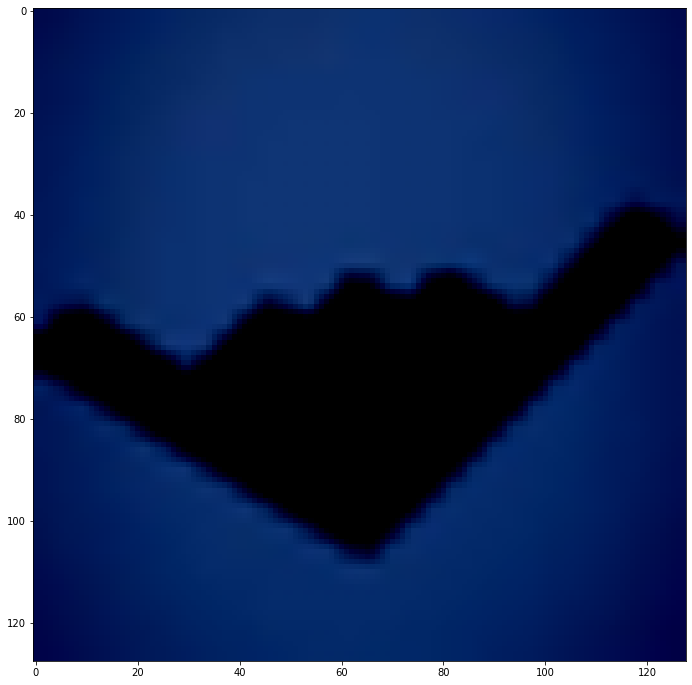

In [3]:
trainloader, _ = loaders()
images, labels = next(iter(trainloader))
vt.show_image(images[3])

In [4]:
encoder = nn.Sequential(nn.Conv2d(3,64, kernel_size=4, stride = 2, padding = 1,),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size = 4, stride = 2),
                        nn.Conv2d(64,64, kernel_size=4, stride = 2, padding = 1,),
                        nn.ReLU())
decoder = nn.Sequential(nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
                        transforms.Resize(128))

model = nn.Sequential(encoder, decoder)
print(model)
model(images).shape

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
  )
  (1): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Resize(size=128, interpolation=PIL.Image.BILINEAR)
  )
)


torch.Size([32, 3, 128, 128])

In [5]:
training = train.Training(autotrain=True)
assert len(training.train_losses) == 0

In [6]:
training.denoise_train(model=model,
               loaders=loaders,
               optimizer=optim.Adam(params=model.parameters(), lr=0.001),
               criterion=nn.MSELoss(), noise_type = 'gaussian',
               epochs=10,
               reload_=False)

Files already downloaded and verified
Files already downloaded and verified
Training on:  cuda
New epoch: 0
Validation loss: 0.248
Training loss: 0.015
New epoch: 1
Validation loss: 0.011
Training loss: 0.011
New epoch: 2
Validation loss: 0.01
Training loss: 0.01
New epoch: 3
Validation loss: 0.009
Training loss: 0.009
New epoch: 4
Validation loss: 0.009
Training loss: 0.009
New epoch: 5
Validation loss: 0.009
Training loss: 0.009
New epoch: 6
Validation loss: 0.009
Training loss: 0.009
New epoch: 7
Validation loss: 0.008
Training loss: 0.009
New epoch: 8
Validation loss: 0.009
Training loss: 0.008
New epoch: 9
Validation loss: 0.008
Training loss: 0.008


Title: 
 

Done training after 1894.7 seconds


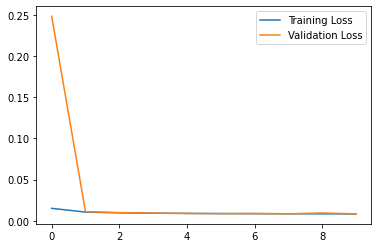

In [7]:
training.summary()
training.save('model_gaussian_10epochs_2layer')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


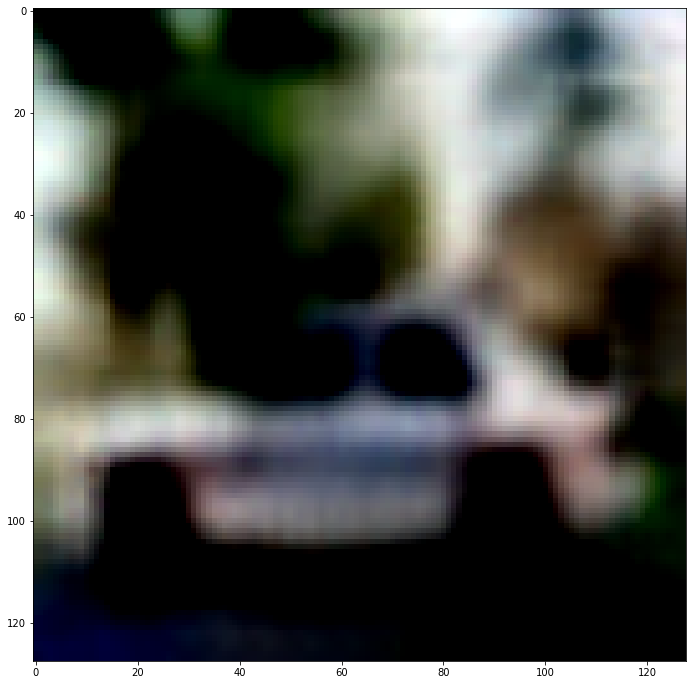

In [13]:
out = model(images.to('cuda'))
vt.show_image(out[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


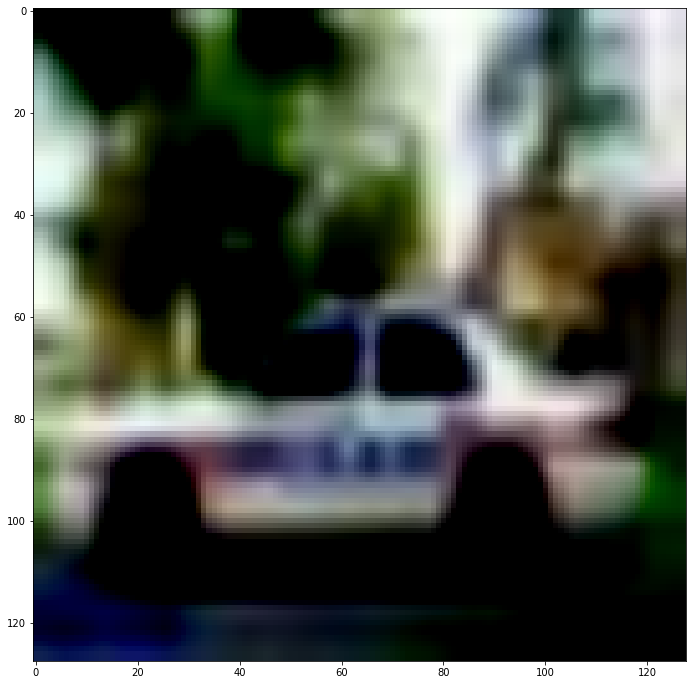

In [12]:
vt.show_image(images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


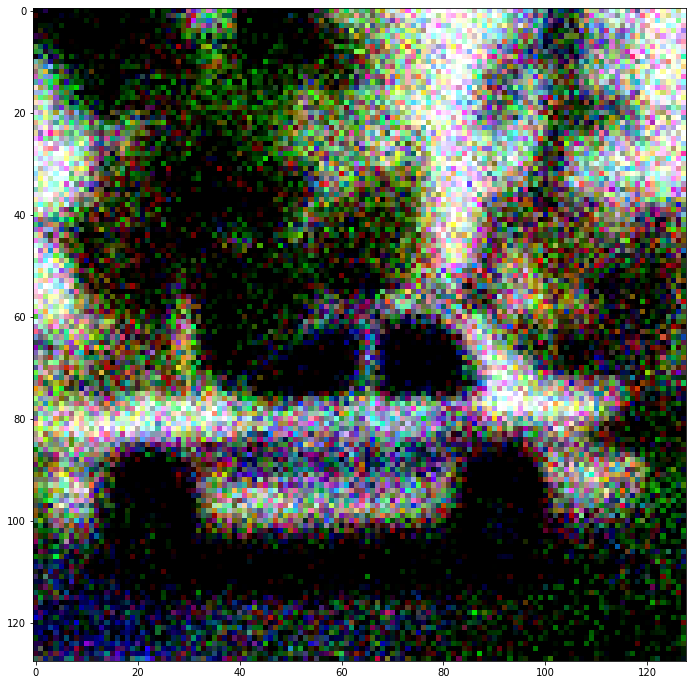

In [14]:
noise_img = random_noise(images, mode='gaussian', mean=0, var=0.05, clip=True)
noise_img = torch.Tensor(noise_img)
vt.show_image(noise_img[0])